In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
#!pip install -U scikit-learn
import sklearn
import inspect
from sklearn import linear_model
from datetime import datetime, timedelta 
import time
from pandas import Timestamp
import requests, pandas, lxml
from lxml import html
def format_date(date_datetime):
     date_timetuple = date_datetime.timetuple()
     date_mktime = time.mktime(date_timetuple)
     date_int = int(date_mktime)
     date_str = str(date_int)
     return date_str
def subdomain(symbol, start, end, filter='history'):
     subdoma="/quote/{0}/history?period1={1}&period2={2}&interval=1d&filter={3}&frequency=1d"
     subdomain = subdoma.format(symbol, start, end, filter)
     return subdomain
 
def header_function(subdomain):
     hdrs =  {"authority": "finance.yahoo.com",
              "method": "GET",
              "path": subdomain,
              "scheme": "https",
              "accept": "text/html",
              "accept-encoding": "gzip, deflate, br",
              "accept-language": "en-US,en;q=0.9",
              "cache-control": "no-cache",
              "cookie": "Cookie:identifier",
              "dnt": "1",
              "pragma": "no-cache",
              "sec-fetch-mode": "navigate",
              "sec-fetch-site": "same-origin",
              "sec-fetch-user": "?1",
              "upgrade-insecure-requests": "1",
              "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64)"}
     
     return hdrs
def scrape_page(url, header):
     page = requests.get(url, headers=header)
     element_html = html.fromstring(page.content)
     table = element_html.xpath('//table')
     table_tree = lxml.etree.tostring(table[0], method='xml')
     panda = pandas.read_html(table_tree)
     return panda
if __name__ == '__main__':
     symbol = 'BB'
     
     dt_start = datetime.today() - timedelta(days=365)
     dt_end = datetime.today()
    
     start = format_date(dt_start)
     end = format_date(dt_end)
     
     sub = subdomain(symbol, start, end)
     header = header_function(sub)
     
     base_url = 'https://finance.yahoo.com'
     url = base_url + sub
     price_history = scrape_page(url, header)

In [2]:
import re
from io import StringIO
from datetime import datetime, timedelta

import requests
import pandas as pd


class YahooFinanceHistory:
    timeout = 2
    crumb_link = 'https://finance.yahoo.com/quote/{0}/history?p={0}'
    crumble_regex = r'CrumbStore":{"crumb":"(.*?)"}'
    quote_link = 'https://query1.finance.yahoo.com/v7/finance/download/{quote}?period1={dfrom}&period2={dto}&interval=1d&events=history&crumb={crumb}'

    def __init__(self, symbol, days_back=7):
        self.symbol = symbol
        self.session = requests.Session()
        self.dt = timedelta(days=days_back)

    def get_crumb(self):
        response = self.session.get(self.crumb_link.format(self.symbol), timeout=self.timeout)
        response.raise_for_status()
        match = re.search(self.crumble_regex, response.text)
        if not match:
            raise ValueError('Could not get crumb from Yahoo Finance')
        else:
            self.crumb = match.group(1)

    def get_quote(self):
        if not hasattr(self, 'crumb') or len(self.session.cookies) == 0:
            self.get_crumb()
        now = datetime.utcnow()
        dateto = int(now.timestamp())
        datefrom = int((now - self.dt).timestamp())
        url = self.quote_link.format(quote=self.symbol, dfrom=datefrom, dto=dateto, crumb=self.crumb)
        response = self.session.get(url)
        response.raise_for_status()
        return pd.read_csv(StringIO(response.text), parse_dates=['Date'])

In [3]:
Walmart = YahooFinanceHistory('AAPL', days_back=(365*5)).get_quote()

In [6]:
Basic_Materials_Sector = ['BHP','LIN','BBL','RIO','CTA-PB','CTA-PA','APD','ECL','VALE','SHW','NEM','GOLD','DD','SCCO','DOW','CRH','FNV','PPG','WPM','LYB','CTVA',
'FCX','NTR','VMC','AEM']

Communication_Services_Sector =['CABO','GOOG','GOOGL','CHTR','NFLX','NTES','SPOT','TWLO','ZM','FB','MSGS','ROKU','TTWO','EA','LBRDA','IAC','BIDU','DIS','SE','TMUS','MTCH','FVRR','CCOI','YY']

Consumer_Cyclical_Sector = ['NVR','AMZN','BKNG','TSLA','CMG','AZO','MELI','ORLY','DPZ','BH-A','LULU','POOL','RH','HD','BABA','W','ULTA','DECK','MTN','MCD','BURL','CVCO','RACE','LAD','MED']

Consumer_Defensive_Sector = ['SAM','GHC','COST','CLX','COKE','EL','MKC-V','MKC','DG','HELE','STZ-B','STZ','STRA','CASY','LANC','EDU','KMB','DEO','HSY','PEP','WMT','BYND','JJSF','PG','TGT']

Financial_Services_Sector = ['BRK-A','FNMFO','MCHB','AFIPA','FINN','FMBL','SBBG','ALPIB','SBNC','BHRB','BAC-PL','WFC-PL','VRTB','MKL','PGPHF','QUCT','WTM','FMIA','USB-PA','FMCB','CBCY','CBCYB','BLK','BKUT','Y']

Real_Estate_Sector = ['TPRP','LAACZ','BVERS','MNPP','CSGP','EQIX','GDVTZ','SBAC','ALX','AMT','AZLCZ','ESS','PSA','ARE','CCI','QTS-PB','AVB','DLR','LEGIF','SUI','PSB','EGP','COR','MAA','FSV']

Consumer_Defensive = ['LDSVF','BYCBF','CAOX','SAM','GHC','COST','LRLCF','COKE','CLX','EL','HELE','MKC-V','MKC','DG','STZ','STZ-B','CASY','LANC','PDRDF','REMYF','KMB','CABJF','HSY','EDU','DEO']

Healthcare_Sector = ['DHR-PA','DHR-PB','BMYMP','SAUHF','MTD','ERFSF','ISRG','ATRI','DWRKF','REGN','LZAGF','BIO-B','CHE','BIO','HUM','DXCM','TMO','TFX','IDXX','RHHBF','ILMN','RHHVF','GNMSF','UNH','SDMHF']

Utilities_Sector = ['NEE','BANGN','WELPM','PPWLM','DOGEF','AWK','AILNP','SRE','CTPPO','DTE','CMS-PB','SRE-PB','SRE-PA','IPWLK','NMK-PC','ALPVN','ATO','APRCP','UEPEO','ETR','PNMXO','DCUE','AILLM','APRDN','UEPEP']

Energy_Sector = ['TPL','AMEN','MITSY','CCRK','TRKX','NOVKY','RSRV','PDER','CEO','PXD','CVX','TTYP','PNRG','LUKOY','REX','PSX','VOPKY','VOPKF','NBR','VLO','LNG','HES','CXO','EOG','TRP']

In [7]:
def Sector_Appender(Sector_list):
    
    table = YahooFinanceHistory(Sector_list[0], days_back=(365*5)).get_quote()
    Sector_list[0] = YahooFinanceHistory(Sector_list[0], days_back=(365*5)).get_quote()
    for index in range(1,len(Sector_list)): 
        data = YahooFinanceHistory(Sector_list[index], days_back=(365*5)).get_quote()
        Sector_list[index] = data
        table = table.append(data)
    return Sector_list

In [8]:
Basic_Materials_table_list = Sector_Appender(Basic_Materials_Sector)
Communication_Services_table_list = Sector_Appender(Communication_Services_Sector)
Consumer_Cyclical_table_list = Sector_Appender(Consumer_Cyclical_Sector)
Financial_Services_Sector_table_list = Sector_Appender(Financial_Services_Sector)
Real_Estate_Sector_table_list = Sector_Appender(Real_Estate_Sector)
Consumer_Defensive_table_list = Sector_Appender(Consumer_Defensive)
Healthcare_Sector_table_list = Sector_Appender(Healthcare_Sector)
Utilities_Sector_table_list = Sector_Appender(Utilities_Sector)
Energy_Sector_table_list =Sector_Appender(Energy_Sector)

ValueError: Could not get crumb from Yahoo Finance

In [ ]:
from sklearn.datasets import make_regression
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

In [ ]:
Basic_Materials_Sector[0]

In [ ]:
RCL = YahooFinanceHistory('RCL', days_back=(365*5)).get_quote()
RCL

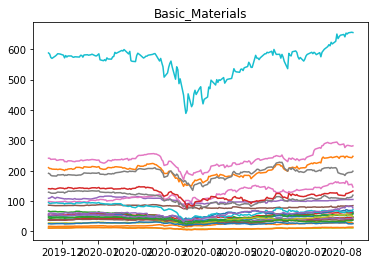

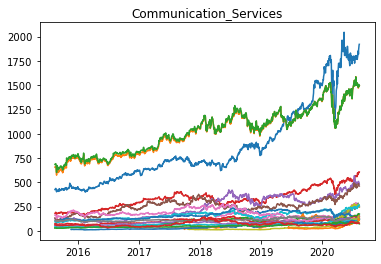

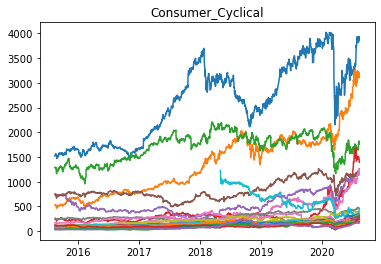

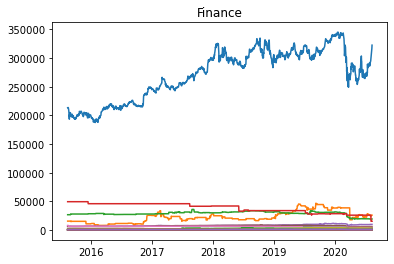

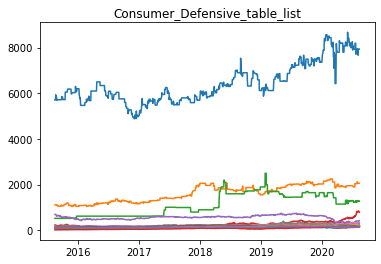

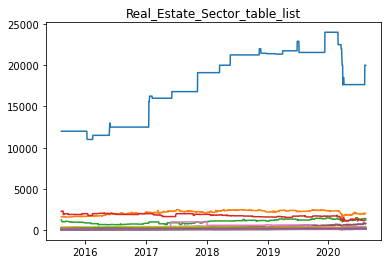

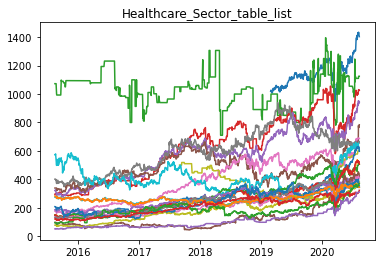

NameError: name 'Utilities_Sector_table_list' is not defined

In [49]:
#RCL.Date[RCL.Date == "2020-01-02"].index.tolist()
#np.std(list(RCL["High"]))
#RCL_trunc = RCL[0:1108]
#RCL_trunc

def stock_analyzer(Company):
    
    USA_COVID_date = Company.Date[Company.Date == "2020-01-02"].index.tolist() #Returns index of the "2020-01-02"
    Company_prior = Company[0:USA_COVID_date[0]]
    Company_post = Company[USA_COVID_date[0]:1257]
    
    Company_prior_Open_min = min(list(Company_prior["Open"]))
    Company_post_Open_min = min(list(Company_post["Open"]))
#    years = [1,2,3,4,5]0 
    if Company_post_Open_min < Company_prior_Open_min:
        #company_name = inspect.getfullargspec(stock_analyzer)[0]
        print("Experienced 5 year low record")
  #      print(str(Company))
    else: 
        print(str(Company))
    return("swaggggggggggg")    
    #plt.plot(Company['Date'],Company['Open'])
    
def stock_analyzer_group(Sector,Sector_name):
    #graph = plt.plot(Sector[0]['Date'],Sector[0]['Open'])
    for company in range(0,len(Sector)):
        #print(Sector[company])
        #stock_analyzer(Sector[company])
        plt.plot(Sector[company]['Date'],Sector[company]['Open'])
        
        #return graph
   # plt.legend(['BHP','LIN','BBL','RIO','CTA-PB','CTA-PA','APD','ECL','VALE','SHW','NEM','GOLD','DD','SCCO','DOW','CRH','FNV','PPG','WPM','LYB','CTVA','FCX','NTR','VMC','AEM'])
    plt.title(Sector_name)
    return plt
#stock_analyzer(RCL)




a = stock_analyzer_group(Basic_Materials_table_list,"Basic_Materials")
a.show()
b = stock_analyzer_group(Communication_Services_table_list,"Communication_Services")
b.show()
c = stock_analyzer_group(Consumer_Cyclical_table_list,"Consumer_Cyclical")
c.show()
d = stock_analyzer_group(Financial_Services_Sector_table_list,"Finance")
d.show()
e= stock_analyzer_group(Consumer_Defensive_table_list,"Consumer_Defensive_table_list")
e.show()
f= stock_analyzer_group(Real_Estate_Sector_table_list,"Real_Estate_Sector_table_list")
f.show()
g= stock_analyzer_group(Healthcare_Sector_table_list,"Healthcare_Sector_table_list")
g.show()
h= stock_analyzer_group(Utilities_Sector_table_list,"Utilities_Sector_table_list")
h.show()
i = stock_analyzer_group(Energy_Sector_table_list,"Energy_Sector_table_list")
i.show()


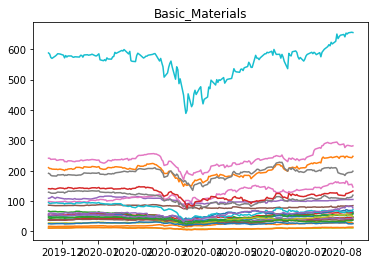

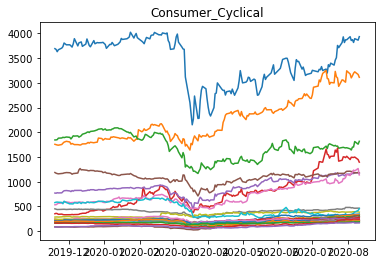

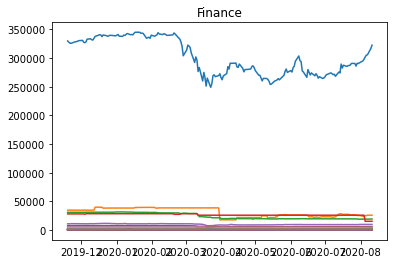

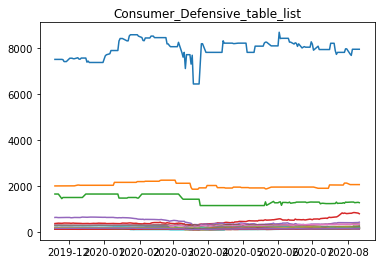

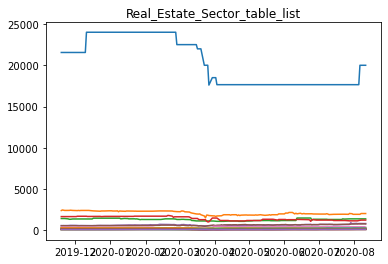

ValueError: Timestamp('2019-11-19 00:00:00') is not in list

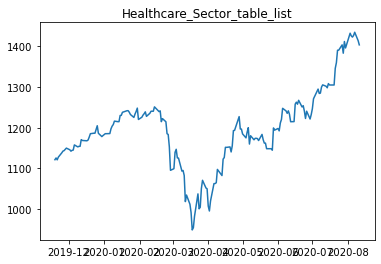

In [56]:
def stock_analyzer_group_Trun(Sector,Sector_name):
    #graph = plt.plot(Sector[0]['Date'],Sector[0]['Open'])
    for company in range(0,len(Sector)):

        November_End_index = (list(Sector[company]['Date']).index(Timestamp('2019-11-19 00:00:00')))
        #print(November_End_index)
        Sector[company] = Sector[company][November_End_index:1300]
        #print(Sector[company]['Date'])
        plt.plot(Sector[company]['Date'],Sector[company]['Open'])
        plt.title(Sector_name)
        #print(list(Sector[company]['Date']))
    return plt


a = stock_analyzer_group_Trun(Basic_Materials_table_list,"Basic_Materials")
a.show()
#b = stock_analyzer_group_Trun(Communication_Services_table_list,"Communication_Services")
#b.show()
c = stock_analyzer_group_Trun(Consumer_Cyclical_table_list,"Consumer_Cyclical")
c.show()
d = stock_analyzer_group_Trun(Financial_Services_Sector_table_list,"Finance")
d.show()
e= stock_analyzer_group_Trun(Consumer_Defensive_table_list,"Consumer_Defensive_table_list")
e.show()
f= stock_analyzer_group_Trun(Real_Estate_Sector_table_list,"Real_Estate_Sector_table_list")
f.show()
g= stock_analyzer_group_Trun(Healthcare_Sector_table_list,"Healthcare_Sector_table_list")
g.show()
h= stock_analyzer_group_Trun(Utilities_Sector_table_list,"Utilities_Sector_table_list")
h.show()
i = stock_analyzer_group_Trun(Energy_Sector_table_list,"Energy_Sector_table_list")
i.show()


In [ ]:

#table1 = YahooFinanceHistory('BHP', days_back=(365*5)).get_quote()
#table2 = YahooFinanceHistory('LIN', days_back=(365*5)).get_quote()
#table3 = YahooFinanceHistory('BBL', days_back=(365*5)).get_quote()


In [ ]:
table4 = table1.append(table2)
table4 = table4.append(table3)
#table5 = 
#plt.plot(table4['Date'],table4['Open'])
#sns.lineplot(x="Date", y="Open", data=table4)
total_cases = pd.read_csv('total_cases.csv')
new_cases = pd.read_csv('new_cases.csv')
total_casesymd = pd.read_csv('total_casesymd.csv')
total_cases = total_cases[2:225]
total_cases = total_cases[["Date","World","United States"]]
total_casesymd = total_casesymd[["Date","World","United States"]]
total_cases 
USA_COVID_date = table1.Date[table1.Date == "2020-01-02"].index.tolist()
table1_covid = table1[0:11]

total_cases

print(type(table1["Date"][0]))

total_cases

total_casesymd['Date'] = pd.to_datetime(total_casesymd['Date'])
new_cases['Date'] = pd.to_datetime(new_cases['Date'])
#table_concat = pd.merge(table1, total_casesymd, how = 'inner', left_index = True, right_index=True)
table_concat = pd.merge(table1, total_casesymd, how = 'left', on='Date')
#df = pd.merge(left_frame, right_frame, how='right', on='key')
table_concat
table_new_cases_concat = pd.merge(table1, new_cases, how = 'left', on='Date')
table_new_cases_concat = table_new_cases_concat.fillna(0)
table_new_cases_concat
swag  = plt.plot(table_new_cases_concat['World'],table_new_cases_concat['Open'])
#plt.plot(table_concat['Date'],table_concat['Close'])

In [ ]:
xval = (table2["Date"][0:1143])
#swag = table2.loc[table2["Date"] == "2020-08-03"]
#xval = list(range(1258))
#print(xval)
yval = table2["Open"][0:1143]
print(yval)

xTrain = xval[0:571]
xTest =  xval[571:1143]
yTrain = yval[0:571]
yTest =  yval[571:1143]

regr = linear_model.LinearRegression()
regr.fit(xTrain, yTrain)
#plt.plot(xval,yval)

